# Helpers

In [15]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from scipy.interpolate import griddata
 

def visualize_stretch(points, stretch_function, output_path):
    xcoords = points[:, 0]
    ycoords = points[:, 1]
    zcoords = points[:, 2]
    X, Y = np.meshgrid(xcoords * 2, ycoords * 2)
    Z = zcoords
    
    xcoords_stretched = np.array([])
    ycoords_stretched = np.array([])
    
    for x, y in zip(xcoords, ycoords):
        xstretched, ystretched = stretch_function(x, y)
        xcoords_stretched = np.append(xcoords_stretched, xstretched)
        ycoords_stretched = np.append(ycoords_stretched, ystretched)

    XStretched, YStretched = np.meshgrid(xcoords_stretched, ycoords_stretched)
    
    # Create a scatter plot for valid points
    fig = go.Figure()

    # Original surface
    fig.add_trace(go.Surface(z=Z, x=X, y=Y, colorscale='Viridis', showscale=True, name='Original Surface'))
    
    # Stretched surface
    fig.add_trace(go.Surface(z=Z, x=XStretched, y=YStretched, colorscale='Cividis', showscale=True, name='Stretched Surface'))

    # Scatter plot for original points
    fig.add_trace(go.Scatter3d(x=xcoords, y=ycoords, z=zcoords, mode='markers', marker=dict(size=5, color='blue'), name='Original Points'))

    # Scatter plot for stretched points
    fig.add_trace(go.Scatter3d(x=xcoords_stretched, y=ycoords_stretched, z=zcoords, mode='markers', marker=dict(size=5, color='red'), name='Stretched Points'))

    fig.update_layout(scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z',
        aspectmode='cube' 
    ))

    fig.show()
    fig.write_image(output_path)
    print(f"Figure saved as {output_path}")

### 2D displacement

#### strecthing

In [16]:
def simple_strecth(x, y):
    x = 2 * x
    y = 1.5 * y
    return x, y

In [17]:
# Define the z-value
z_value = 5.0

# Define the vertices of the polygon (square in this case)
points = np.array([
    [0, 0, z_value],  # Bottom-left
    [1, 0, z_value],  # Bottom-right
    [1, 1, z_value],  # Top-right
    [0, 1, z_value],  # Top-left
    [0, 0, z_value]   # Closing the polygon
])

In [18]:
visualize_stretch(points = points, stretch_function=simple_strecth, output_path="simple_stretch.png")

Figure saved as simple_stretch.png


#### Shear

In [19]:
def shear(x, y):
    x = x + y 
    y = 0.5 * x + y
    return x, y

In [20]:
visualize_stretch(points = points, stretch_function=shear, output_path="shear.png")

Figure saved as shear.png


#### General Deform

In [21]:
def deform1(x, y):
    x = 1.3 * x - 0.375 * y
    y = 0.75 * x + 0.65 * y 
    return x, y

In [22]:
visualize_stretch(points = points, stretch_function=deform1, output_path="shear.png")

Figure saved as shear.png


### Deformation Gradient

In [ ]:
import autograd.numpy as np
from autograd import jacobian

def deform(coords):
    x, y = coords
    x_out = 1.3 * x - 0.375 * y
    y_out = 0.75 * x + 0.65 * y
    return np.array([x_out, y_out])


def shear(coords):
    x, y = coords
    x_out = x + y 
    y_out = 0.5 * x + y
    return np.array([x_out, y_out])


def calculate_deformation_tensor(deform_function):
    gradient_function = jacobian(deform_function)
    return gradient_function

F = calculate_deformation_tensor(deform)
coords = np.array([1.0, 1.0])
F(coords) + np.eye(2)



array([[ 2.3  , -0.375],
       [ 0.75 ,  1.65 ]])

In [26]:
import matplotlib.pyplot as plt

def visualize_deformation(deform_function):
    F = calculate_deformation_tensor(deform_function)

    # Generate a grid of points in the original space
    x_vals, y_vals = np.linspace(-1, 1, 10), np.linspace(-1, 1, 10)
    X, Y = np.meshgrid(x_vals, y_vals)
    coords_grid = np.stack([X.ravel(), Y.ravel()], axis=-1)

    # Calculate the deformation (displaced points) and gradients at each point in the grid
    deformed_points = np.array([deform_function(coord) for coord in coords_grid])
    deformation_gradients = np.array([F(coord) + np.eye(2) for coord in coords_grid])

    # Calculate displacements and magnitudes for each point in the grid
    displacements = deformed_points - coords_grid
    magnitude = np.linalg.norm(displacements, axis=1)

    # Plotting the deformation field
    plt.figure(figsize=(8, 8))
    plt.quiver(coords_grid[:, 0], coords_grid[:, 1], 
            displacements[:, 0], displacements[:, 1], 
            magnitude, angles='xy', scale_units='xy', scale=1, cmap="viridis")

    # Plot original and deformed points for reference
    plt.plot(coords_grid[:, 0], coords_grid[:, 1], 'bo', markersize=3, label="Original Grid")
    plt.plot(deformed_points[:, 0], deformed_points[:, 1], 'ro', markersize=3, label="Deformed Grid")
    plt.colorbar(label="Deformation Magnitude")
    plt.axis('equal')
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("Deformation Gradient Visualization")
    plt.legend()
    plt.show()


In [27]:
visualize_deformation(deform1)

TypeError: deform1() missing 1 required positional argument: 'y'

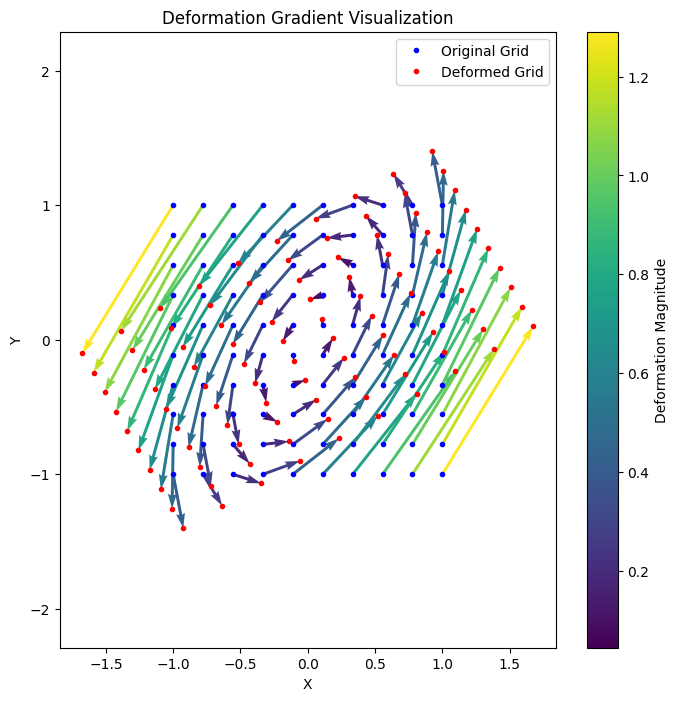

In [ ]:
visualize_deformation(deform1)

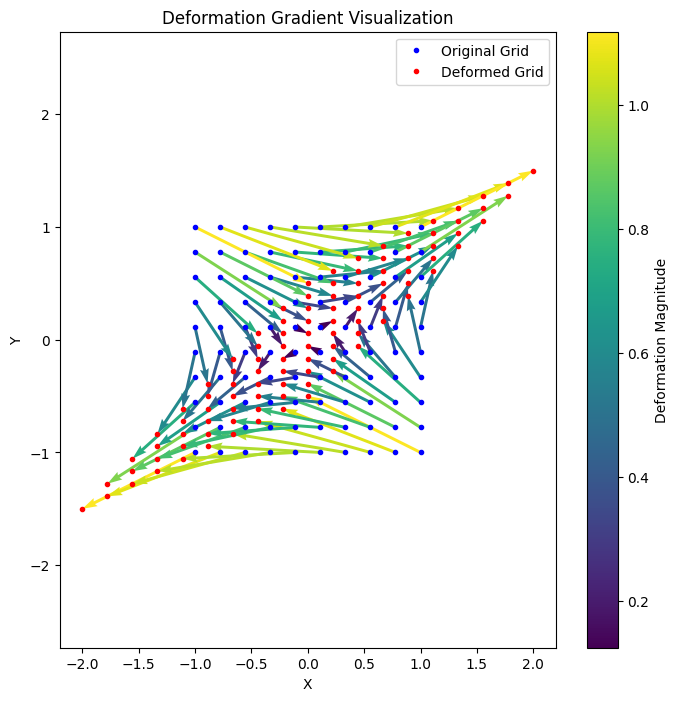

In [64]:
visualize_deformation(shear) 

### Visualize Strain Tensor

In [71]:
F = calculate_deformation_tensor(deform)

strain_tensor = 1/2 * (np.transpose(F(coords)) @ F(coords) - np.eye(2))
strain_tensor

array([[ 6.26250000e-01, -1.38777878e-17],
       [-1.38777878e-17, -2.18437500e-01]])

In [ ]:
def visualize_strain_tensor(deform_function):
    F = calculate_deformation_tensor(deform)
    x_vals, y_vals = np.linspace(-1, 1, 10), np.linspace(-1, 1, 10)
    X, Y = np.meshgrid(x_vals, y_vals)
    coords_grid = np.stack([X.ravel(), Y.ravel()], axis=-1)
    deformed_points = np.array([deform_function(coord) for coord in coords_grid])
    deformation_gradients = np.array([F(coord) + np.eye(2) for coord in coords_grid])
    displacements = deformed_points - coords_grid
    magnitude = np.linalg.norm(displacements, axis=1)
    plt.figure(figsize=(8, 8))
    plt.quiver(coords_grid[:, 0], coords_grid[:, 1], 
            displacements[:, 0], displacements[:, 1], 
            magnitude, angles='xy', scale_units='xy', scale=1, cmap="viridis")
    plt.plot(coords_grid[:, 0], coords_grid[:, 1], 'bo', markersize=3, label="Original Grid")
    plt.plot(deformed_points[:, 0], deformed_points[:, 1], 'ro', markersize=3, label="Deformed Grid")
    plt.colorbar(label="Deformation Magnitude")
    plt.axis('equal')
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("Strain Tensor Visualization")
    plt.legend()
    plt.show()
    